# Creating seperate DataFrames

To start, we'll read in our headline data with our clusters and create two DataFrames: one with points only in the United States, and all the points outside the US.

In [1]:
import pandas as pd
import numpy as np


df = pd.read_csv("data/clustered_headlines.csv")
df_us = df[df['countrycode']=='US'].copy()
df_world = df[df['countrycode']!='US'].copy()

In [2]:
from mpl_toolkits.basemap import Basemap
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt

world_plotter = Basemap()
# From Data Science Bookcamp: Plotting Maps using Basemap
us_plotter = Basemap(projection='lcc', lon_0=-95, llcrnrlon=-119, llcrnrlat=22,
                     urcrnrlon=-64, urcrnrlat=49, lat_1=33, lat_2=45)

In [3]:
# Helper function to eliminate redundant code while plotting cluster maps.
# Note that this function doesn't draw any countries/boundaries nor show the matplotlib map,
# so it is the caller's responsibility to plot the boundaries and map type they want.
def plot_clusters(data_frame, map_plotter):
    plt.figure(figsize=(20, 12))
    cluster_group = data_frame.groupby('cluster')
    for cluster_id, cluster in cluster_group:
        if cluster_id == -1: continue
        #map_plotter.scatter(np.array(cluster.longitude), np.array(cluster.latitude), latlon=True)
        map_plotter.scatter(cluster.longitude.to_numpy(), cluster.latitude.to_numpy(), latlon=True)
    plt.legend( [f"Cluster {cid}" for cid, _ in cluster_group if cid != -1], \
               loc="lower left", markerscale=2, fontsize="medium" )

# Re-clustering: World

Since the old clusters no longer apply to our dataset, we'll have to re-cluster both of our datasets, starting with the non-US points.

In [4]:
# Current "good" world parameters: eps=9, min_samples=6
EPS=9
MIN_SAMPLES=6
clusters = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES).fit_predict(df_world[['latitude', 'longitude']].to_numpy())
df_world['cluster'] = clusters

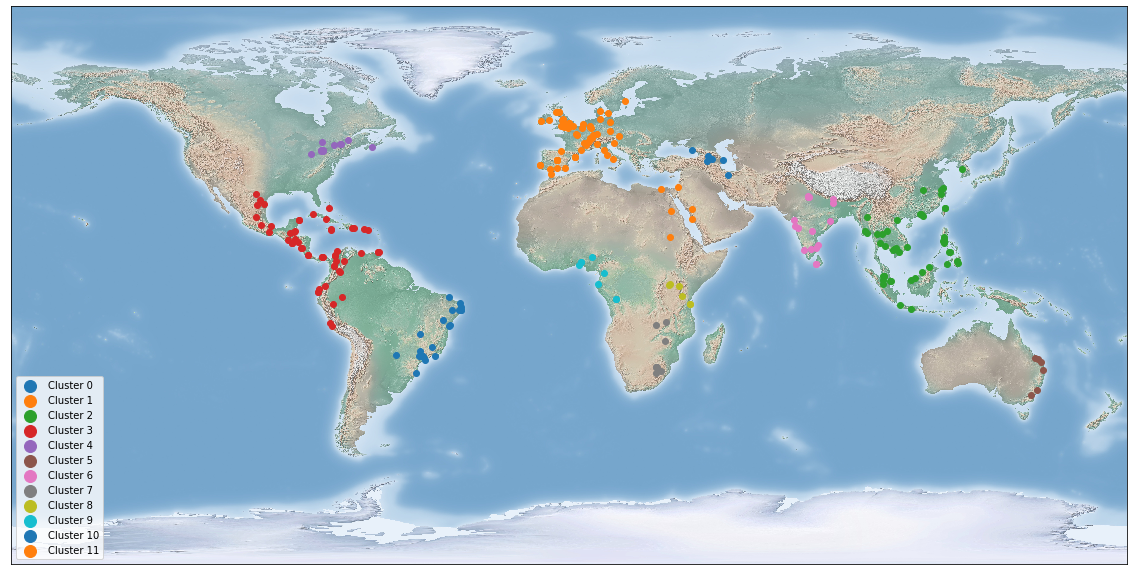

In [5]:
plot_clusters(df_world, world_plotter)
#world_plotter.drawcoastlines()
#world_plotter.drawcountries()
world_plotter.shadedrelief()
plt.show()

In [6]:
df_world.groupby('cluster').count().sort_values('headline', ascending=False)

headline  city  latitude  longitude  countrycode
cluster                                                  
 1             63    63        63         63           63
 2             56    56        56         56           56
 3             56    56        56         56           56
-1             44    44        44         44           44
 0             21    21        21         21           21
 6             16    16        16         16           16
 4             11    11        11         11           11
 7              8     8         8          8            8
 9              8     8         8          8            8
 5              6     6         6          6            6
 8              6     6         6          6            6
 10             6     6         6          6            6
 11             6     6         6          6            6

# Re-clustering: United States

Now, its time to recluster our United States data. We're probably going to try different parameters here, since the distance between cities is much smaller.

In [7]:
EPS = 2
MIN_SAMPLES = 6
clusters = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES).fit_predict(df_us[['latitude', 'longitude']].to_numpy())
df_us['cluster'] = clusters

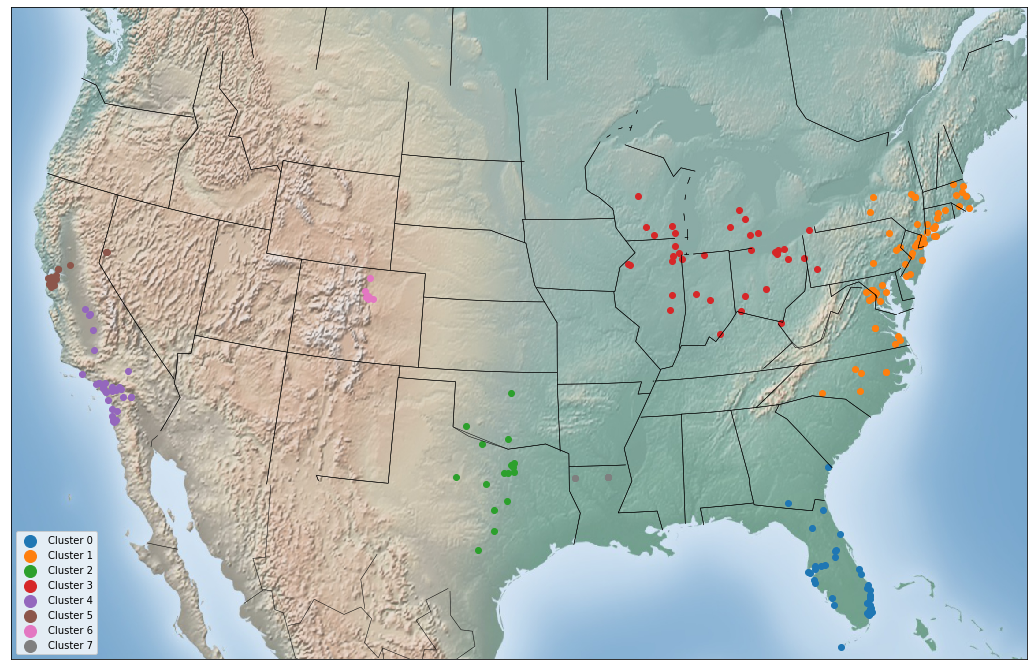

In [8]:
plot_clusters(df_us, us_plotter)
us_plotter.shadedrelief()
#us_plotter.drawcoastlines()
us_plotter.drawstates()
plt.show()

In [9]:
df_us.groupby('cluster').count().sort_values('headline', ascending=False)

headline  city  latitude  longitude  countrycode
cluster                                                  
-1             78    78        78         78           78
 1             70    70        70         70           70
 0             41    41        41         41           41
 3             36    36        36         36           36
 4             32    32        32         32           32
 2             16    16        16         16           16
 5             15    15        15         15           15
 6              7     7         7          7            7
 7              6     6         6          6            6

# Finding Cluster Centers: Naïve Implementation

We'll find the center of each cluster for the US and World datasets, in order to locate headlines closet to the center of each cluster. For this verison, we'll do a simple average over all the Lat/Long points to represent the center.

In [10]:
us_centers_naive = {cluster_id: (np.mean(cluster.latitude), np.mean(cluster.longitude)) \
                             for cluster_id, cluster in df_us.groupby('cluster')}
world_centers_naive = {cluster_id: (np.mean(cluster.latitude), np.mean(cluster.longitude)) \
                             for cluster_id, cluster in df_world.groupby('cluster')}

In [11]:
# Based on the Haversine formula, found here: https://www.movable-type.co.uk/scripts/latlong.html
import math
def great_circle(point_1, point_2):
    RADIUS = 6371  # Kilometers, Earth's mean radius
    lat_1 = math.radians(point_1[0])
    lat_2 = math.radians(point_2[0])
    d_lat = lat_2 - lat_1
    d_long = math.radians(point_2[1] - point_1[1])
    a = math.sin(d_lat/2)**2 + math.cos(lat_1) * math.cos(lat_2) * math.sin(d_long/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    return RADIUS * c

Next up, we'll create a new DataFrame to sort the headlines in each cluster by their proximity to the center we just calculated.

In [12]:
# We'll do the US distances from their respective cluster centers first
dist_from_center = [great_circle((lat, lng), us_centers_naive[clust]) for lat, lng, clust \
                        in zip(df_us.latitude, df_us.longitude, df_us.cluster)]
df_us['dist_from_center'] = dist_from_center

# Next up are the world distances from their respective cluster centers
dist_from_center = [great_circle((lat, lng), world_centers_naive[clust]) for lat, lng, clust \
                        in zip(df_world.latitude, df_world.longitude, df_world.cluster)]
df_world['dist_from_center'] = dist_from_center

In [13]:
df_us.sort_values(by=['cluster', 'dist_from_center'], inplace=True)
df_world.sort_values(by=['cluster', 'dist_from_center'], inplace=True)

In [14]:
df_us.sample(n=10)

headline         city  latitude  \
496  Lower Hospitalization in Janesville after Vari...   Janesville  42.68279   
213  Authorities are Worried about the Spread of Ro...        Union  40.69760   
170                    BREAKING aEUR" Zika in Missoula     Missoula  46.87215   
251  Rumors about Mumps Spreading in New Bedford ha...  New Bedford  41.63526   
58          New Zika Case Confirmed in Sarasota County     Sarasota  27.33643   
261                    Zika Troubles come to Harlingen    Harlingen  26.19063   
223                How to Avoid Hepatitis B in Waldorf      Waldorf  38.62456   
255  Albany Residents Recieve Respiratory Syncytial...       Albany  42.65258   
522            More Zika patients reported in Lakeland     Lakeland  28.03947   
250                  Tuberculosis Outbreak in Hartford     Hartford  41.76371   

     longitude countrycode  cluster  dist_from_center  
496  -89.01872          US        3        335.407234  
213  -74.26320          US        1        103.474474  
170 -113.99400          US       -1       1597.927371  
251  -70.92701          US        1        392.470847  
58   -82.53065          US        0        148.236654  
261  -97.69610          US       -1       1221.787250  
223  -76.93914          US        1        222.089212  
255  -73.75623          US        1        315.508959  
522  -81.94980          US        0        130.391375  
250  -72.68509          US        1        280.366026

In [15]:
df_world.sample(n=10)

headline         city  latitude  \
596                    Varicella has Arrived in Milton       Milton  43.51681   
563                        Chlamydia Exposure in Sanaa        Sanaa  15.35472   
172  Sick Livestock Leads to Serious Trouble for Be...      Belfort  47.64218   
93                       Spreading Zika reaches Bacoor       Bacoor  14.45896   
194                        Mad Cow Disease Hits Naples       Naples  40.85216   
124                    Norovirus Exposure in Hong Kong    Hong Kong  22.27832   
552                            Zika Outbreak in Manaus       Manaus  -3.10194   
575  How to Avoid Contaminated Meat when Visiting B...        Basel  47.55839   
458                     Spanish Flu Outbreak in Lisbon       Lisbon  38.71667   
308  Rumors about HIV spreading in Montpellier have...  Montpellier  43.61092   

     longitude countrycode  cluster  dist_from_center  
596  -79.88294          CA        4        314.336233  
563   44.20667          YE       -1       1929.014972  
172    6.85385          FR        1        319.468539  
93   120.93851          PH        2        902.227787  
194   14.26811          IT        1       1221.066656  
124  114.17469          HK        2        983.100107  
552  -60.02500          BR       -1      10051.738598  
575    7.57327          CH        1        374.207502  
458   -9.13333          PT        1       1403.948574  
308    3.87723          FR        1        503.755186

# Examining Headlines

With the data now sorted by closest point to the center of each cluster, we can now examine the data to see if there are trends of certain outbreaks in each cluster. From there, we can start noting common diseases.

## Examining Headlines: US

In [16]:
for c_id, cluster in df_us.groupby('cluster'):
    print(f"US Cluster: {c_id}")
    print(cluster.sample(n=6)['headline'])

US Cluster: -1
145    Rumors about Rotavirus spreading in Huntsville...
170                      BREAKING aEUR" Zika in Missoula
546    Rumors about Hepatitis E Spreading in Morristo...
51     Seattle scientists get $500,000 grant to pursu...
377                     Ogden is infested with Gonorrhea
338        New medicine wipes out Mumps in Saint Charles
Name: headline, dtype: object
US Cluster: 0
564        Zika Reported in North Miami Beach
19      Tampa Bay Area Zika Case Count Climbs
600    Zika symptoms spotted in Boynton Beach
562                Zika spreads to Plant City
17       Orlando volunteers aid Zika research
49          Zika symtomps spotted in Key West
Name: headline, dtype: object
US Cluster: 1
590                 Influenza Keeps Spreading in Suffolk
304       Malaria Vaccine is now Required in Schenectady
583              Case of Norovirus Reported in Stratford
255    Albany Residents Recieve Respiratory Syncytial...
214    Rumors about Hepatitis D spreading in Albany

After a few samplings, it's clear that Clusters 0 and 2 have a Zika outbreak. Clusters 4 and 5 appear to have a few Zika headlines as well, so we should look into those.

In [17]:
df_us[(df_us.cluster==4) & (df_us.headline.str.lower().str.contains("zika"))]

headline          city  \
193                      Zika Virus Arrives in Ontario       Ontario   
358                        Zika arrives in Orange City        Orange   
245                 Zika symptoms spotted in Hollywood     Hollywood   
279                   Outbreak of Zika in Palm Springs  Palm Springs   
149  Escondido neighborhood to get sprayed for Zika...     Escondido   
27            Key Zika Findings in San Diego Institute     San Diego   

     latitude  longitude countrycode  cluster  dist_from_center  
193  34.06334 -117.65089          US        4         21.944470  
358  33.78779 -117.85311          US        4         36.671416  
245  34.09834 -118.32674          US        4         41.156108  
279  33.83030 -116.54529          US        4        127.158343  
149  33.11921 -117.08642          US        4        133.072708  
27   32.71571 -117.16472          US        4        169.358993

In [18]:
df_us[(df_us.cluster==5) & (df_us.headline.str.lower().str.contains("zika"))]

headline           city  latitude  \
34            Zika Virus Reaches San Francisco  San Francisco  37.77493   
150             Zika in Belmont, Belmont worry        Belmont  37.52021   
225  Zika Virus Sparks 'International Concern'         Sparks  39.53491   

     longitude countrycode  cluster  dist_from_center  
34  -122.41942          US        5         64.313976  
150 -122.27580          US        5         74.777720  
225 -119.75269          US        5        240.037986

Clusters 4 and 5 definitely show several Zika cases, but nothing nearly as dense as clusters 0 and 2.

## Examining Headlines: World

In [19]:
for c_id, cluster in df_world.groupby('cluster'):
    print(f"World Cluster: {c_id}")
    print(cluster.sample(n=6)['headline'])

World Cluster: -1
285             West Nile Virus re-emerges in Wellington
473    More people in Yokohama are infected with Noro...
276    More people in Saint Petersburg are infected w...
559                            Zika Outbreak in Mexicali
146                     Rhinovirus has Arrived in Athens
478       Chikungunya Keeps Spreading in North Vancouver
Name: headline, dtype: object
World Cluster: 0
517                       Zika case reported in Limoeiro
535              More Zika patients reported in Botucatu
281                                Zika arrives in Natal
72                      Student sick in Campinas, Brazil
368    Pedro Juan Caballero Encounters Severe Symptom...
42                   Zika outbreak in Piracicaba, Brazil
Name: headline, dtype: object
World Cluster: 1
330                   Spike of Dengue Cases in Stockholm
578                     Mad Cow Disease Detected in Lyon
7                  Geneve Scientists Battle to Find Cure
490    Authorities are Worried ab

Clusters 0, 2, 3, 6 show very high concentrations of Zika headlines. Cluster 1 shows a different trend of Mad Cow Disease.

# Pinpointing Disease Outbreaks

Now that we've looked at each of the clusters and identified several frequently-occurring diseases, we'll now map the outbreaks of each disease.

In [20]:
MIN_OUTBREAKS = 10
known_diseases = { "Zika", "Mad Cow Disease" }

## Pinpointing Disease Outbreaks: US Plotting

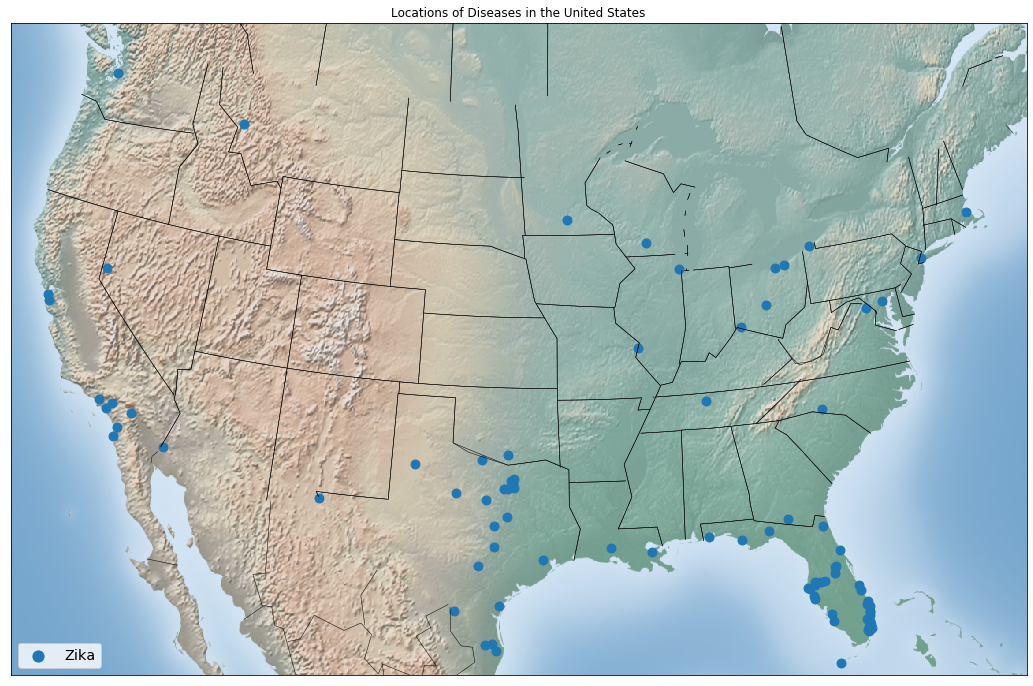

In [21]:
# US plotting
plt.figure(figsize=(20, 12))
for disease in known_diseases:
    disease_us = df_us[df_us['headline'].str.contains(disease)]
    if len(disease_us) < MIN_OUTBREAKS: continue  # Don't bother with small occurrences of diseases
    us_plotter.scatter(disease_us.longitude.to_numpy(), disease_us.latitude.to_numpy(), \
                       latlon=True, s=80, label=disease)
plt.title("Locations of Diseases in the United States")
us_plotter.shadedrelief()
us_plotter.drawstates()
plt.legend(loc="lower left", markerscale=1.25, fontsize="x-large")
#plt.savefig(f"US_Disease_Map.png", dpi=300, orientation="landscape")
plt.show()

## Pinpointing Disease Outbreaks: World Plotting

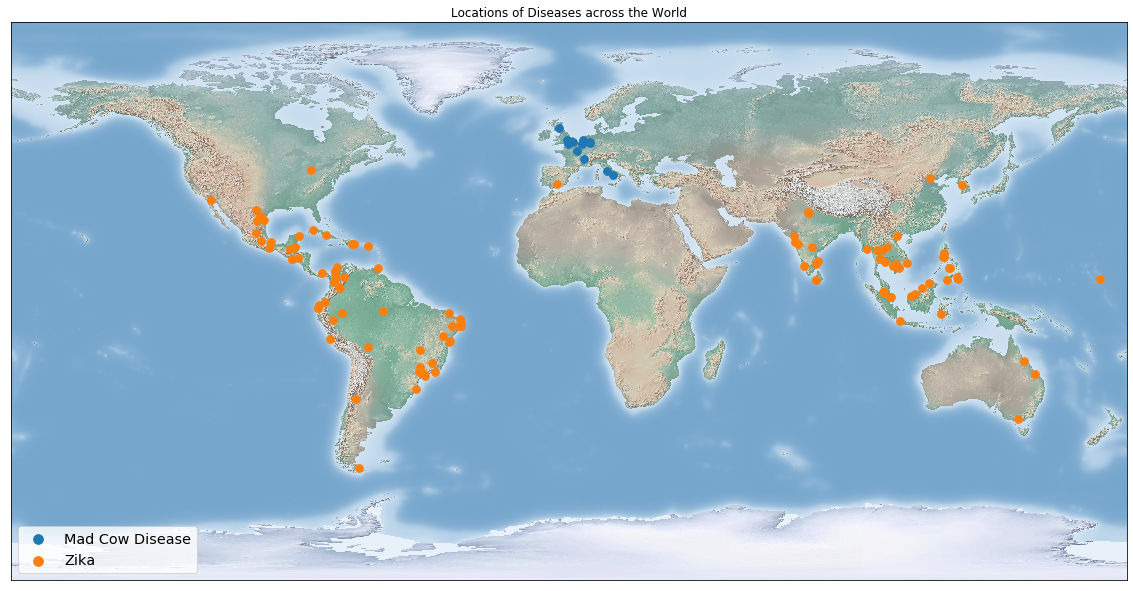

In [22]:
# World plotting
plt.figure(figsize=(20, 12))
for disease in known_diseases:
    disease_world = df_world[df_world['headline'].str.contains(disease)]
    if len(disease_world) < MIN_OUTBREAKS: continue  # Don't bother with small occurrences of diseases
    world_plotter.scatter(disease_world.longitude.to_numpy(), disease_world.latitude.to_numpy(), \
                              latlon=True, s=60, label=disease)
plt.title("Locations of Diseases across the World")
world_plotter.shadedrelief()
plt.legend(loc="lower left", markerscale=1.25, fontsize="x-large")
#plt.savefig(f"World_Disease_Map.png", dpi=300, orientation="landscape")
plt.show()

With these maps in hand, it's clear that the world is facing a Zika pandemic (in addition to a Mad Cow Disease epidemic in Europe), and action must be taken. For our last step, we'll create a data-set and world map of only clusters with outbreaks of Zika.

In [23]:
# We'll adjust the US cluster IDs to fit in the World dataset without being 
# counted as part of an already-existing world cluster.
# US Cluster 0 -> 12, US 2 -> 14, US 4 -> 16, US 5 -> 17
df_us.loc[:, 'cluster'] += 12

In [25]:
z = pd.concat([df_us, df_world])
zika_frame = z[z['cluster'].isin([0, 2, 3, 6, 12, 14, 16, 17])].sort_values(by='cluster')
zika_frame.drop(axis=1, labels='dist_from_center', inplace=True)
zika_frame.to_csv("data/clustered_zika_locations.csv", index=False)

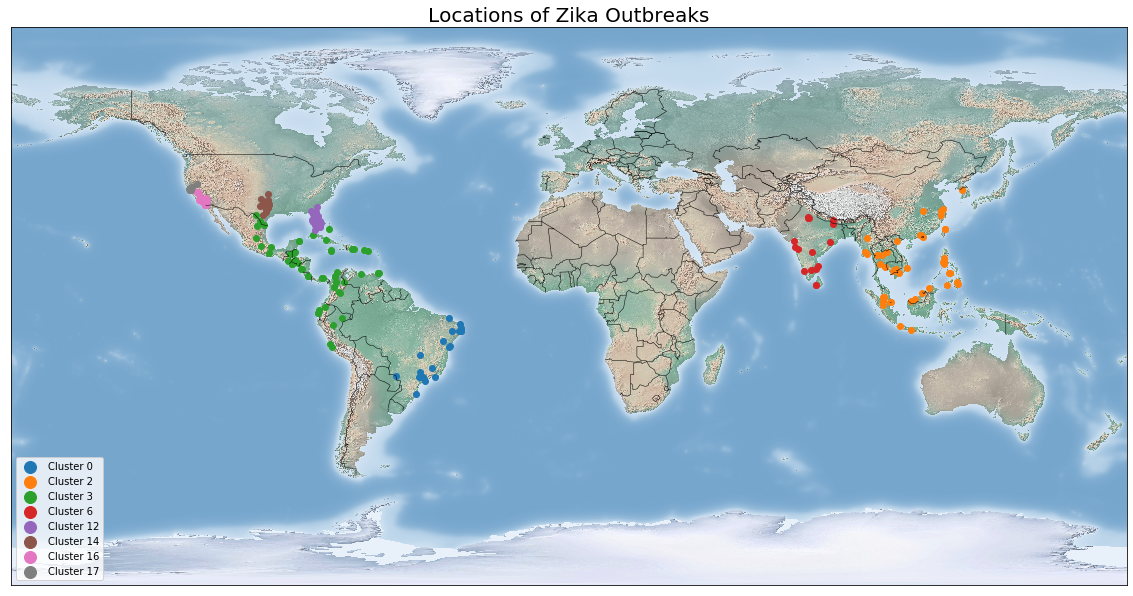

In [26]:
plot_clusters(zika_frame, world_plotter)
world_plotter.drawcountries()
world_plotter.shadedrelief()
plt.title("Locations of Zika Outbreaks", fontsize=20)
plt.savefig("Locations_of_Zika_Outbreaks.png", dpi=300, orientation="landscape")